In [37]:
import json
import pandas as pd
import os
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter
from pathlib import Path
import plotly.express as px

In [2]:
DATA_FILES = [f for f in Path('data').glob('*.json')]

In [3]:
# Load data
author_affiliations = {}
all_papers = []
for filename in DATA_FILES:
    venue = filename.stem
    year = int(venue[-2:]) + 2000
    with open(filename) as f:
        papers = json.load(f)
    for paper in papers:
        authors = []
        affiliations = []
        for author in paper['authors']:
            # TODO check if any author changed affiliations. Yep, that happens...
            name = author['name']
            affiliation = author['affiliation']
            author_affiliations[name] = affiliation
            authors.append(name)
            affiliations.append(affiliation)
        paper['authors'] = authors
        paper['affiliations'] = affiliations
        paper['venue'] = venue
        paper['year'] = year
        all_papers.append(paper)
papers = pd.DataFrame(all_papers)
papers.head()

title  \
0                     Changing the face of computing   
1  Principles, priorities, and pressures: persona...   
2  This much I know: thoughts on the past, presen...   
3                                   Online education   
4  Unlocking the clubhouse: a decade later and no...   

                                             link  \
0  https://dl.acm.org/doi/10.1145/2445196.2445198   
1  https://dl.acm.org/doi/10.1145/2445196.2445199   
2  https://dl.acm.org/doi/10.1145/2445196.2445200   
3  https://dl.acm.org/doi/10.1145/2445196.2445201   
4  https://dl.acm.org/doi/10.1145/2445196.2445202   

                                            abstract            authors  \
0  The demand for computing professionals continu...       [Tracy Camp]   
1  Early discussion regarding a talk at the First...     [Henry Walker]   
2  Tools to support and improve the learning and ...  [Michael Kölling]   
3  There has been an explosion of interest in Onl...  [John Etchemendy]   
4  In the decade since Unlocking the Clubhouse: W...    [Jane Margolis]   

                         tags  \
0  [broadening participation]   
1       [career perspectives]   
2         [educational tools]   
3          [online education]   
4  [broadening participation]   

                                        affiliations     venue  year  
0        [Colorado School of Mines, Golden, CO, USA]  SIGCSE13  2013  
1              [Grinnell College, Grinnell, IA, USA]  SIGCSE13  2013  
2   [University of Kent, Canterbury, United Kingdom]  SIGCSE13  2013  
3           [Stanford University, Stanford, CA, USA]  SIGCSE13  2013  
4  [University of California at Los Angeles, Los ...  SIGCSE13  2013

In [4]:
# Define functions
def find_keywords(keywords):
    def find(row):
        search_str = row.title.lower() + row.abstract.lower() + ''.join(t.lower() for t in row.tags)
        for word in keywords:
            if word in search_str:
                return 1
        return 0
    return find


def papers_with_keywords_percent(papers, keywords):
    found = papers.apply(find_keywords(keywords), axis=1).sum()
    return 100 * found / len(papers)


def sort_by_occurrence(values, decreasing=True):
    c = Counter(values)
    return sorted(((count, v) for v, count in c.items()), reverse=decreasing)

# Counting some keywords

In [5]:
search_keywords = [
    ['automatic', 'automated'],
    ['project'],
    ['assess'],
    ['peer'],
    ['review'],
    ['code'],
    ['test'],
    ['active learning'],
    ['game'],
]
years = sorted(papers.year.unique())
for keywords in search_keywords:
    print(f'KEYWORDS: {", ".join(keywords)}')
    for year in years:
        papers_by_year = papers[papers.year == year]
        print(f'{year}: {papers_with_keywords_percent(papers_by_year, keywords):.2f}% of the papers include the keywords')
    print()

KEYWORDS: automatic, automated
2010: 1.82% of the papers include the keywords
2011: 0.00% of the papers include the keywords
2012: 3.47% of the papers include the keywords
2013: 4.00% of the papers include the keywords
2014: 4.42% of the papers include the keywords
2015: 6.50% of the papers include the keywords
2016: 4.71% of the papers include the keywords
2017: 6.86% of the papers include the keywords
2018: 5.22% of the papers include the keywords
2019: 5.01% of the papers include the keywords
2020: 6.05% of the papers include the keywords

KEYWORDS: project
2010: 18.18% of the papers include the keywords
2011: 18.34% of the papers include the keywords
2012: 17.92% of the papers include the keywords
2013: 18.67% of the papers include the keywords
2014: 25.85% of the papers include the keywords
2015: 24.15% of the papers include the keywords
2016: 22.22% of the papers include the keywords
2017: 23.47% of the papers include the keywords
2018: 25.66% of the papers include the keywords
2

# Common Author Tags

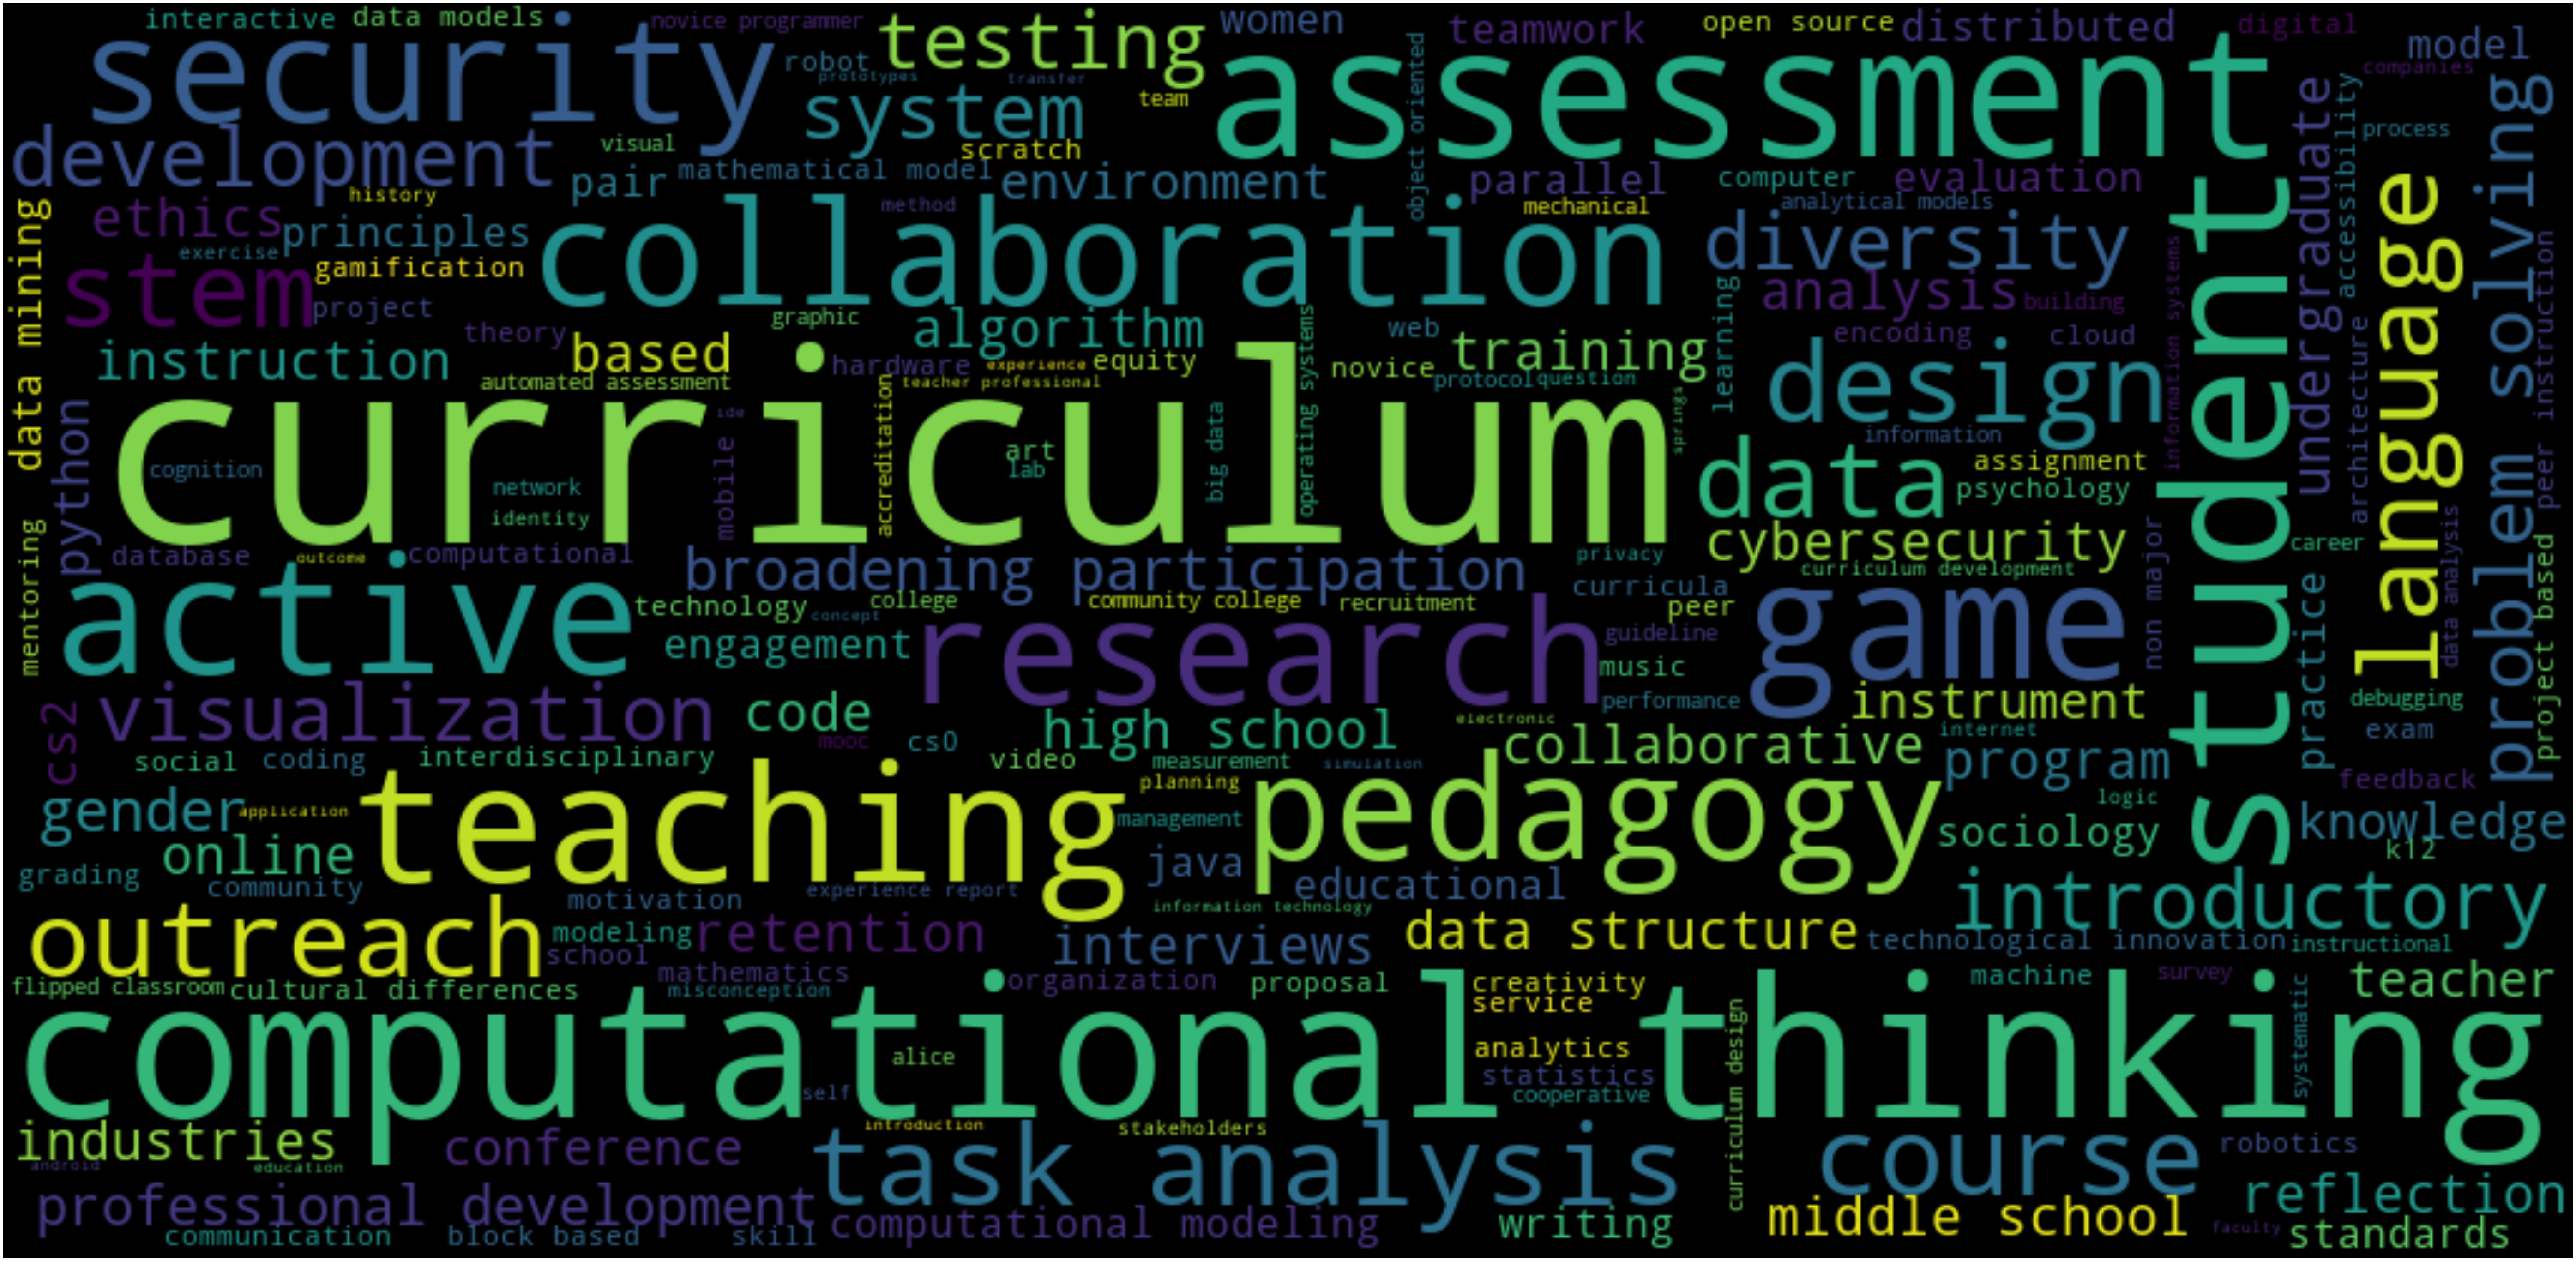

In [6]:
ignore = ['programming', 'education', 'learning', 'computer', 'science', 'computing', 'student', 'cs1', 'tool', 'cs', 'engineering', 'software', 'tools', 'profession']
all_tags = (w.lower().strip() for t in papers.tags.sum() for w in t.split())
all_tags = ' '.join(w for w in all_tags if w not in ignore)
wordcloud = WordCloud(width=1024, height=500).generate(all_tags)
fig, ax = plt.subplots(figsize=(100, 50))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
pass

In [46]:
all_tags = [t.lower() for t in papers.tags.sum()]
for count, tag in sort_by_occurrence(all_tags):
    if count > 10:
        print(f'{tag} ({count} publications)')

education (476 publications)
computer science education (345 publications)
cs1 (257 publications)
tools (210 publications)
computational thinking (200 publications)
programming (157 publications)
computer science (155 publications)
active learning (151 publications)
assessment (127 publications)
task analysis (119 publications)
curriculum (117 publications)
engineering education (106 publications)
engineering profession (105 publications)
programming profession (104 publications)
collaboration (101 publications)
engineering students (100 publications)
pedagogy (99 publications)
stem (92 publications)
software (88 publications)
k-12 (88 publications)
software engineering (86 publications)
interviews (82 publications)
diversity (81 publications)
visualization (79 publications)
outreach (73 publications)
computing education (73 publications)
reflection (71 publications)
games (71 publications)
k-12 education (70 publications)
broadening participation (70 publications)
professional develop

In [51]:
def filter_tags_by_year(row):
    tags = row.tags
    year = int(row.venue[-2:]) + 2000
    return [{'year': year, 'tag': tag.lower()} for tag in tags]

tags_by_year = pd.DataFrame(papers.apply(filter_tags_by_year, axis=1).sum())
tag_counts = tags_by_year.groupby('tag').count()
popular_tags = list(tag for tag in tag_counts[tag_counts.year > 20].index if tag)
popular_tags_by_year = tags_by_year[tags_by_year.tag.isin(popular_tags)]
tby = popular_tags_by_year.groupby(['tag', 'year']).year.count().unstack().fillna(0)
tby[tby[2018] < tby[2020]]

year                      2010  2011  2012  2013  2014  2015  2016  2017  \
tag                                                                        
accessibility              0.0   1.0   0.0   1.0   2.0   2.0   2.0   6.0   
android                    0.0   3.0   4.0   7.0   2.0   4.0   0.0   0.0   
assessment                 8.0   4.0   5.0   8.0   4.0   9.0   8.0  14.0   
block-based programming    0.0   0.0   0.0   0.0   0.0   1.0   1.0   3.0   
broadening participation   3.0   1.0   0.0   4.0   5.0  12.0   8.0   3.0   
computational thinking     8.0   9.0   5.0  19.0  15.0  11.0  10.0  19.0   
computing education        0.0   0.0   1.0   4.0   4.0   2.0   2.0   1.0   
cs2                        3.0   2.0   0.0   8.0   6.0   7.0   7.0   4.0   
curriculum                11.0   3.0   8.0  10.0  11.0  14.0   5.0   9.0   
cybersecurity education    0.0   0.0   0.0   0.0   0.0   0.0   2.0   3.0   
debugging                  1.0   0.0   0.0   1.0   0.0   1.0   2.0   1.0   
diversity                  3.0   3.0   2.0   6.0   6.0   5.0   8.0  10.0   
equity                     0.0   0.0   0.0   1.0   1.0   0.0   2.0   2.0   
experience report          1.0   0.0   4.0   1.0   4.0   1.0   2.0   0.0   
flipped classroom          0.0   0.0   0.0   3.0   1.0   7.0   3.0   1.0   
gamification               0.0   0.0   0.0   2.0   4.0   1.0   4.0   2.0   
gender                     4.0   2.0   2.0   4.0   4.0   2.0   1.0  12.0   
k-12                       3.0   2.0   2.0   4.0   6.0   9.0   9.0  10.0   
non-majors                 2.0   3.0   2.0   5.0   3.0   4.0   1.0   5.0   
novice programmers         1.0   2.0   0.0   0.0   0.0   2.0   3.0   1.0   
pogil                      0.0   0.0   2.0   2.0   3.0   3.0   3.0   7.0   
problem solving            1.0   0.0   0.0   1.0   3.0   3.0   1.0   2.0   
robotics                   2.0   4.0   0.0   6.0   1.0   2.0   1.0   3.0   
scratch                    6.0   1.0   5.0   5.0   3.0   3.0   4.0   4.0   
student engagement         0.0   1.0   0.0   0.0   2.0   3.0   1.0   0.0   
teaching                   1.0   1.0   1.0   1.0   3.0   3.0   3.0   0.0   

year                      2018  2019  2020  
tag                                         
accessibility              6.0   9.0  10.0  
android                    1.0   2.0   3.0  
assessment                18.0  26.0  23.0  
block-based programming    3.0   5.0   9.0  
broadening participation   7.0  14.0  13.0  
computational thinking    29.0  38.0  37.0  
computing education       16.0  20.0  23.0  
cs2                        7.0   8.0   8.0  
curriculum                10.0  18.0  18.0  
cybersecurity education    8.0   9.0   9.0  
debugging                  7.0   7.0   8.0  
diversity                 13.0  11.0  14.0  
equity                     8.0  12.0  14.0  
experience report          2.0   1.0   5.0  
flipped classroom          4.0   1.0   5.0  
gamification               3.0  11.0   6.0  
gender                    10.0  12.0  12.0  
k-12                      10.0  14.0  19.0  
non-majors                 2.0   3.0   4.0  
novice programmers         5.0   7.0   7.0  
pogil                      3.0   3.0   4.0  
problem solving            1.0   8.0   4.0  
robotics                   3.0   4.0   4.0  
scratch                    6.0   4.0   7.0  
student engagement         5.0   8.0   7.0  
teaching                   4.0   6.0   6.0

In [73]:
groups = {
    'gender and diversity': ['women in computing', 'broadening participation in computing', 'gender', 'gender and diversity', 'diversity', 'gender issues', 'women', 'cs for all'],
    'accessibility': ['accessibility', 'disability'],
    'automated grading': ['automated grading', 'grading', 'unit testing', 'autograding', 'automated assessment'],
    'gamification': ['games', 'gamification'],
    'soft skills': ['soft skills', 'communication', 'teamwork'],
    'online learning': ['online learning', 'online education', 'mooc'],
    'peer instruction': ['peer review', 'cooperative learning', 'peer instruction', 'collaborative learning', 'pair programming'],
    'open source': ['open source'],
    'feedback': ['feedback'],
    'interdisciplinary': ['interdisciplinary'],
    'project-based learning': ['project-based learning'],
    'ethics': ['ethics'],
    'active learning': ['active learning'],
}

tby = tags_by_year
for group in groups:
    for tag in groups[group]:
        tby.loc[tby.tag == tag,'tag'] = group

tby = tby.groupby(['tag', 'year']).year.count()
tby = tby.rename('total').reset_index()
selected_tby = tby[tby.tag.isin(groups.keys())]
fig = px.line(selected_tby, x='year', y='total', color='tag', title='')
fig.show()

# Authors

In [10]:
for count, name in sort_by_occurrence(papers.authors.sum()):
    if count > 5:
        print(f'{name} ({count} publications)') 

Daniel D. Garcia (40 publications)
Leo Porter (37 publications)
Tiffany Barnes (36 publications)
Kristy Elizabeth Boyer (32 publications)
Mark Guzdial (31 publications)
Daniel Zingaro (28 publications)
Joel C. Adams (27 publications)
Jeff Gray (27 publications)
Clifford A. Shaffer (27 publications)
Diana Franklin (26 publications)
Stephen H. Edwards (24 publications)
Jens Mache (24 publications)
Elizabeth Shoop (23 publications)
Colleen M. Lewis (23 publications)
Andrew Petersen (23 publications)
Adrienne Decker (23 publications)
Helen H. Hu (22 publications)
Monica M. McGill (21 publications)
Christina Gardner-McCune (21 publications)
Brett A. Becker (21 publications)
Mehran Sahami (20 publications)
Mark Sherriff (20 publications)
Barbara Ericson (20 publications)
Siddharth Kaza (19 publications)
Samuel A. Rebelsky (19 publications)
Richard Weiss (19 publications)
Owen Astrachan (19 publications)
Chris Mayfield (19 publications)
Blair Taylor (19 publications)
Ursula Wolz (18 publicati